In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
# Pytorch package
import torch
import torch.nn as nn
from torchmetrics.regression import MeanAbsolutePercentageError

In [35]:
df = pd.read_csv("cgm_data.csv")
for column in df.columns:
    df[column] = df[column].astype(float)
df.rename({0:"ID"}, axis=1)
df = df.drop("ptid", axis=1)
df = df.iloc[:-1 , :]

In [36]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [37]:
# Define constants
N_EPOCHS = 20
NHEAD = 1
NHID = 64
NLAYERS = 2
LR = 0.01
training_patients = 5
EMBED_DIM=4
prediction_horizon = 1

In [38]:
class PositionalEncoding(nn.Module): # from https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 500, device='cuda'):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model).to(device)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [39]:
# Define the transformer model
class TransformerModel(nn.Module):
    def __init__(self, embed_dim, nhead, num_layers, dim_feedforward):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(500, embed_dim, device = 'cuda')
        self.pos_encoder = PositionalEncoding(d_model = embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_dim, nhead, dim_feedforward), num_layers)
        
        self.linear = nn.Linear(embed_dim, 1)
        
        self.mask_dict={}
        for i in range(480):
            self.mask_dict[i] = self.generate_square_subsequent_mask(i)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz,device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        mask = self.mask_dict[x.size(0)]
        x = x.type(torch.LongTensor).to(device)
        x = self.embedding(x)
        x = x.squeeze(2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x,)# mask)
        x = self.linear(x)
        return x

# Function to split the data
def train_test_split(df, training_patients, prediction_horizon, device):
    train_input = torch.from_numpy(df.iloc[:training_patients,:-prediction_horizon].values).float().to(device)
    train_target = torch.from_numpy(df.iloc[:training_patients, prediction_horizon:].values).float().to(device)
    test_input = torch.from_numpy(df.iloc[training_patients:,:-prediction_horizon].values).float().to(device)
    test_target = torch.from_numpy(df.iloc[training_patients:, prediction_horizon:].values).float().to(device)

    train_input = torch.unsqueeze(train_input, -1).permute(1, 0, 2)
    train_target = torch.unsqueeze(train_target, -1).permute(1, 0, 2)
    test_input = torch.unsqueeze(test_input, -1).permute(1, 0, 2)
    test_target = torch.unsqueeze(test_target, -1).permute(1, 0, 2)
    return train_input, train_target, test_input, test_target

In [40]:
train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

# Initialize the model
model = TransformerModel(embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
criterion = MeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
test_losses = []
avg_test_losses = []
all_test_outputs = torch.zeros(test_input.shape).to(device)


for epoch in tqdm(range(N_EPOCHS)):
    model.train()
    for t in range(0, train_input.shape[0]):
        for patient in range(training_patients):# Loop over the time steps in each epoch
            optimizer.zero_grad()
            output = model(train_input[:t+1,patient,:])
            if len(output.shape) < 3:
                output = output.unsqueeze(0)
            loss = criterion(output, train_target[:t+1,patient,:].unsqueeze(2))
            loss.backward()
            optimizer.step()
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'At epoch {epoch}, Training Loss {loss.item()}')


    model.eval()

    with torch.no_grad():
        test_losses = []  # Collect test losses at each time step
        for t in range(0, test_input.shape[0]):
            test_output = model(test_input[:t+1,:,:])
            #all_test_outputs[:t, :] = test_output.unsqueeze(-1)  # Adjust dimensions here
            test_loss = criterion(test_output, test_target[:t+1,:,:])
            test_losses.append(test_loss.item())
        avg_test_loss = np.mean(test_losses)
        avg_test_losses.append(avg_test_loss)

    if epoch % 10 == 0:
        print(f'Test Loss at epoch {epoch} is {avg_test_loss}')


torch.Size([479, 5, 1])
torch.Size([479, 5, 1])
torch.Size([479, 91, 1])
torch.Size([479, 91, 1])


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

At epoch 0, Training Loss 0.04892142862081528


  5%|████▏                                                                              | 1/20 [00:14<04:31, 14.31s/it]

Test Loss at epoch 0 is 0.09584179223517038


 50%|█████████████████████████████████████████                                         | 10/20 [02:24<02:27, 14.79s/it]

At epoch 10, Training Loss 0.029341187328100204


 55%|█████████████████████████████████████████████                                     | 11/20 [02:40<02:16, 15.12s/it]

Test Loss at epoch 10 is 0.08699582881121147


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:58<00:00, 14.94s/it]


In [41]:
avg_test_loss

0.08409578054521179

In [8]:
train_target[:1,1,:].shape

torch.Size([1, 1])

In [9]:
train_target[:t+1,patient,:].shape

torch.Size([1, 1])

In [9]:
train_target[:t+1,patient,:]

tensor([[120.6000]], device='cuda:0')

In [ ]:
torch.save(model, "simpletransformer")

In [ ]:
plt.figure()
plt.plot(range(N_EPOCHS), train_losses, label = "Training Loss")
plt.plot(range(N_EPOCHS), avg_test_losses, label = "Test Loss")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Epochs")
plt.title("Simple Transformer Learning Curve")
plt.legend()
plt.show()
print(test_losses[-1])

In [ ]:
def draw(true, pred, index, color):
    true = true.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array
    pred = pred.detach().cpu().numpy()  # Detach the tensor from the computation graph, move it to cpu and convert to numpy array

    plt.figure(figsize=(10, 5))
    plt.title(f"test patient {index}")
    plt.xlabel("time step")
    plt.ylabel("glucose level")
    n = true.shape[0]
    plt.plot(np.arange(n), true[:, index], color, label="True")
    plt.plot(np.arange(n), pred[:, index], color + ":", label="Predicted")
    plt.legend()
    plt.show()

print(test_target.shape)
print(all_test_outputs.shape)

draw(test_target, all_test_outputs, 0, 'r')
draw(test_target, all_test_outputs, 1, 'r')
draw(test_target, all_test_outputs, 2, 'r')
draw(test_target, all_test_outputs, 3, 'r')
draw(test_target, all_test_outputs, 4, 'r')
draw(test_target, all_test_outputs, 5, 'r')

**Graph 2 Variable Time Horizon**

In [20]:
final_test_losses = []

prediction_horizons = range(1, 9)

for prediction_horizon in prediction_horizons:
  print(f'Prediction Horizon: {prediction_horizon}\n')
  train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)

  # Initialize the model
  model = TransformerModel(d_model=1, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
  criterion = MeanAbsolutePercentageError().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  train_losses = []
  test_losses = []
  avg_test_losses = []
  all_test_outputs = torch.zeros(test_input.shape).to(device)


  for epoch in range(N_EPOCHS):
      model.train()
      for t in range(timestep, train_input.shape[0]):  # Loop over the time steps in each epoch
          optimizer.zero_grad()
          output = model(train_input[:t]).squeeze(-1)
          loss = criterion(output[:, -1], train_target[:t, -timestep].squeeze(-1))
          loss.backward()
          optimizer.step()
      train_losses.append(loss.item())

      if epoch % 10 == 0:
          print(f'At epoch {epoch}, Training Loss {loss.item()}')


      model.eval()
      with torch.no_grad():
          test_losses = []  # Collect test losses at each time step
          for t in range(timestep, test_input.shape[0]):
              test_output = model(test_input[:t]).squeeze(-1)
              all_test_outputs[:t, :] = test_output.unsqueeze(-1)  # Adjust dimensions here
              test_loss = criterion(test_output[:, -1], test_target[:t, -timestep].squeeze(-1))
              test_losses.append(test_loss.item())
          avg_test_loss = np.mean(test_losses)
          avg_test_losses.append(avg_test_loss)

          if epoch % 10 == 0:
            print(f'Test Loss at epoch {epoch} is {avg_test_loss}')
  final_test_losses.append(avg_test_losses[-1])

Prediction Horizon: 1



TypeError: __init__() got an unexpected keyword argument 'd_model'

In [85]:
final_test_losses

[0.33098310738739606,
 0.33368311942685824,
 0.3368684519317095,
 0.3406926217675209,
 0.3440687212629346,
 0.34923753353430403,
 0.3528809734635939,
 0.35616995935227463]

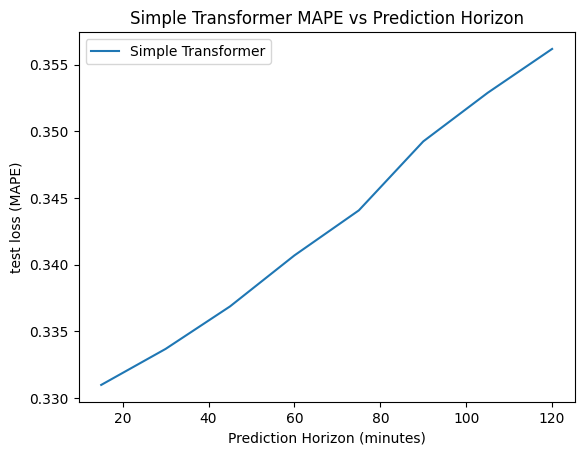

In [86]:
# Training Curve
plt.figure()
plt.plot([15*x for x in prediction_horizons],final_test_losses, label = "Simple Transformer")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Prediction Horizon (minutes)")
plt.title("Simple Transformer MAPE vs Prediction Horizon")
plt.legend()
plt.show()

Graph 3 Variable Training Patients

In [89]:
training_patients_sizes = [1,10,20,30,40,50,60,70,80,90]

final_test_losses = []


for training_patients in training_patients_sizes:
  print(f'Training Patient Size: {training_patients}\n')
  train_input, train_target, test_input, test_target = train_test_split(df, training_patients, prediction_horizon, device)

  # Initialize the model
  model = TransformerModel(d_model=1, nhead=NHEAD, num_layers=NLAYERS, dim_feedforward=NHID).to(device)
  criterion = MeanAbsolutePercentageError().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)

  train_losses = []
  test_losses = []
  avg_test_losses = []
  all_test_outputs = torch.zeros(test_input.shape).to(device)


  for epoch in range(N_EPOCHS):
      model.train()
      for t in range(timestep, train_input.shape[0]):  # Loop over the time steps in each epoch
          optimizer.zero_grad()
          output = model(train_input[:t]).squeeze(-1)
          loss = criterion(output[:, -1], train_target[:t, -timestep].squeeze(-1))
          loss.backward()
          optimizer.step()
      train_losses.append(loss.item())

      if epoch % 10 == 0:
          print(f'At epoch {epoch}, Training Loss {loss.item()}')


      model.eval()
      with torch.no_grad():
          test_losses = []  # Collect test losses at each time step
          for t in range(timestep, test_input.shape[0]):
              test_output = model(test_input[:t]).squeeze(-1)
              all_test_outputs[:t, :] = test_output.unsqueeze(-1)  # Adjust dimensions here
              test_loss = criterion(test_output[:, -1], test_target[:t, -timestep].squeeze(-1))
              test_losses.append(test_loss.item())
          avg_test_loss = np.mean(test_losses)
          avg_test_losses.append(avg_test_loss)

          if epoch % 10 == 0:
            print(f'Test Loss at epoch {epoch} is {avg_test_loss}')
  final_test_losses.append(avg_test_losses[-1])

Training Patient Size: 1

At epoch 0, Training Loss 0.5028061270713806
Test Loss at epoch 0 is 0.6787495929470994
Training Patient Size: 10

At epoch 0, Training Loss 0.5308899879455566
Test Loss at epoch 0 is 0.6594011993671426
Training Patient Size: 20

At epoch 0, Training Loss 0.5097207427024841
Test Loss at epoch 0 is 0.6429427282572299
Training Patient Size: 30

At epoch 0, Training Loss 0.46560126543045044
Test Loss at epoch 0 is 0.6302549952914
Training Patient Size: 40

At epoch 0, Training Loss 0.4134085476398468
Test Loss at epoch 0 is 0.6338289502826213
Training Patient Size: 50

At epoch 0, Training Loss 0.546760618686676
Test Loss at epoch 0 is 0.6429498910650833
Training Patient Size: 60

At epoch 0, Training Loss 0.5809990167617798
Test Loss at epoch 0 is 0.6422896652211556
Training Patient Size: 70

At epoch 0, Training Loss 0.5990908145904541
Test Loss at epoch 0 is 0.6439832193330088
Training Patient Size: 80

At epoch 0, Training Loss 0.5645631551742554
Test Loss at

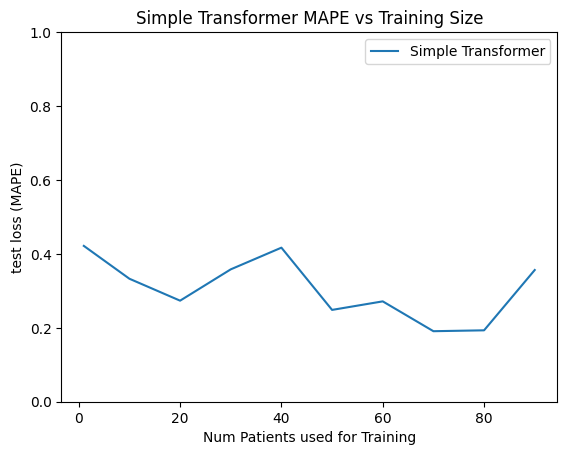

In [90]:
#Training Curve
plt.figure()
plt.plot(training_patients_sizes,final_test_losses, label = "Simple Transformer")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Num Patients used for Training")
plt.title("Simple Transformer MAPE vs Training Size")
plt.ylim(0,1)
plt.legend()
plt.show()